In [9]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_squared_error as RMSE
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Part 1
# Overall Goals

The Goal of this project is 2 fold.  The first is to perform import, and analysis, and predictions of the BBC News dataset using Non-Negative Matrix Factorization.  There will be testing with various sizes of training data and various levels of reduction as well as 3 or 4 different algorithims to perform predictions. 

As I have never done text analasys before I used [https://towardsdatascience.com/using\-nmf\-to\-classify\-companies\-a77e176f276f](https://towardsdatascience.com/using-nmf-to-classify-companies-a77e176f276f)  as a guide on how to do this.



<span style='font-size:medium'>**Import and EDA**</span>

I am analyzing BBC news articles with the goal of being able to categorize the news articles.  I start by importing the data and factorizing the data.  I split the data using TF\-IDF which uses the count of words penalized by how often the word happens in different documents.  It returns values for each word between 0 and 1 with 0 being not present.



In [10]:
data = pd.read_csv("https://raw.githubusercontent.com/isaac1987a/Week-4/main/BBC/Data/BBC_News_Train.csv")
print(data.head())
vectorizer = TfidfVectorizer(input='content', encoding='utf-8', 
                             decode_error='strict', strip_accents='unicode', 
                             lowercase=True, preprocessor=None, tokenizer=None, 
                             analyzer='word', max_df=1.0, min_df=1, max_features=None, 
                             sublinear_tf=True, ngram_range=(1,2))
#Combine Data into category matricies
data = data.drop(columns = ['ArticleId'])

#Vectorize Results
text_matrix = vectorizer.fit_transform(data.Text)
#Sparse Matrix of results
#print(text_matrix)
#Get Word List
word_list = vectorizer.get_feature_names_out()


   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business


In [11]:
# Convert sparse matrix to array
text_array = text_matrix.toarray()

# Create pandas dataframe with column names as word_list
text_dataframe = pd.DataFrame(text_array, columns=word_list)
text_dataframe.index = list(data.Category)
# Print first few rows of resulting dataframe
print(text_dataframe.head())
print(text_dataframe.shape)


           00  00 and  00 for  00 mark  00 per       000  000 12  000 130  \
business  0.0     0.0     0.0      0.0     0.0  0.000000     0.0      0.0   
business  0.0     0.0     0.0      0.0     0.0  0.000000     0.0      0.0   
business  0.0     0.0     0.0      0.0     0.0  0.014521     0.0      0.0   
tech      0.0     0.0     0.0      0.0     0.0  0.013526     0.0      0.0   
business  0.0     0.0     0.0      0.0     0.0  0.000000     0.0      0.0   

          000 133  000 267  ...  zurich according  zurich and  \
business      0.0      0.0  ...               0.0         0.0   
business      0.0      0.0  ...               0.0         0.0   
business      0.0      0.0  ...               0.0         0.0   
tech          0.0      0.0  ...               0.0         0.0   
business      0.0      0.0  ...               0.0         0.0   

          zurich premiership  zutons  zutons at  zvonareva  zvonareva has  \
business                 0.0     0.0        0.0        0.0           

To start with, I validated that all categories are fairly well balanced.  This ensures that I don't have to do any normalizing for unblalanced data.

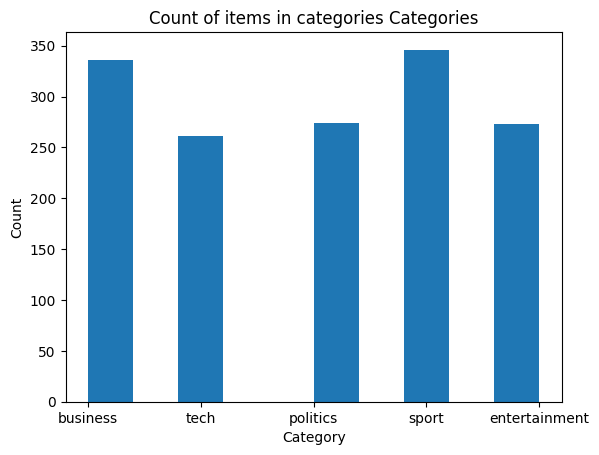

In [12]:

#shows the data is balanced between categories
def plot_balance(dat):
    plot2 = plt.hist(dat.index)
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.title('Count of items in categories Categories')
    plt.show()
plot_balance(text_dataframe)



I now selected the most common words for each category by adding the values of each column.  This turned into an unexpected result.  Common words have distinct categories of association, but the top 10 words are very commonly shared too.  I'm going to reload the dataset while excluding common English words.

I have no idea where the 6th color is coming from.  I gave up looking.  If you figure it out, please drop me a comment.

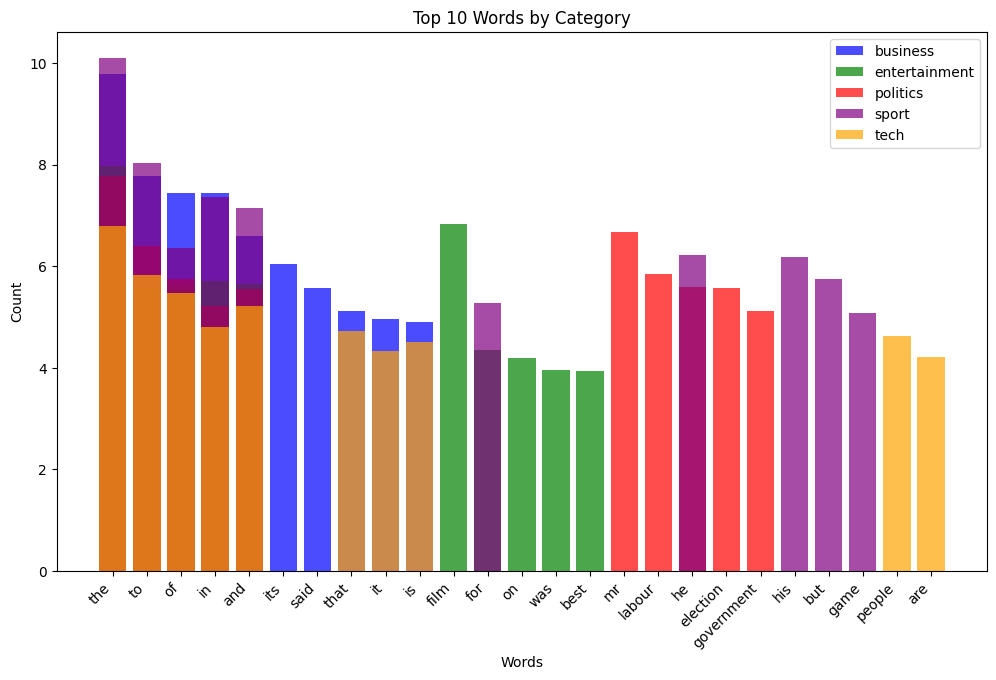

In [13]:
#The plot the sum of each categories words.
def graph_frame(text_dataframe):
    grouped_frame = text_dataframe.groupby(level = 0).sum()

    top_n = 10
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    fig, ax = plt.subplots(figsize=(12, 7))
    for i, category in enumerate(grouped_frame.index):
        top_words = grouped_frame.loc[category].sort_values(ascending=False).iloc[:top_n]
        ax.bar(top_words.index, top_words.values, color=colors[i], alpha=0.7, label=category)

    ax.set_xlabel('Words')
    ax.set_ylabel('Count')
    ax.set_title(f'Top {top_n} Words by Category')
    plt.xticks(rotation=45, ha='right')
    ax.legend()
    plt.show()

graph_frame(text_dataframe)

After reviewing the data, there are few words and they have lots of overlap between categories.  I researched and found that TfidfVectorizer has the option to remove words.  I used the built in list of common words from the English language.  This seems to have resolved the overlap and now I have each category with distinct most common words.


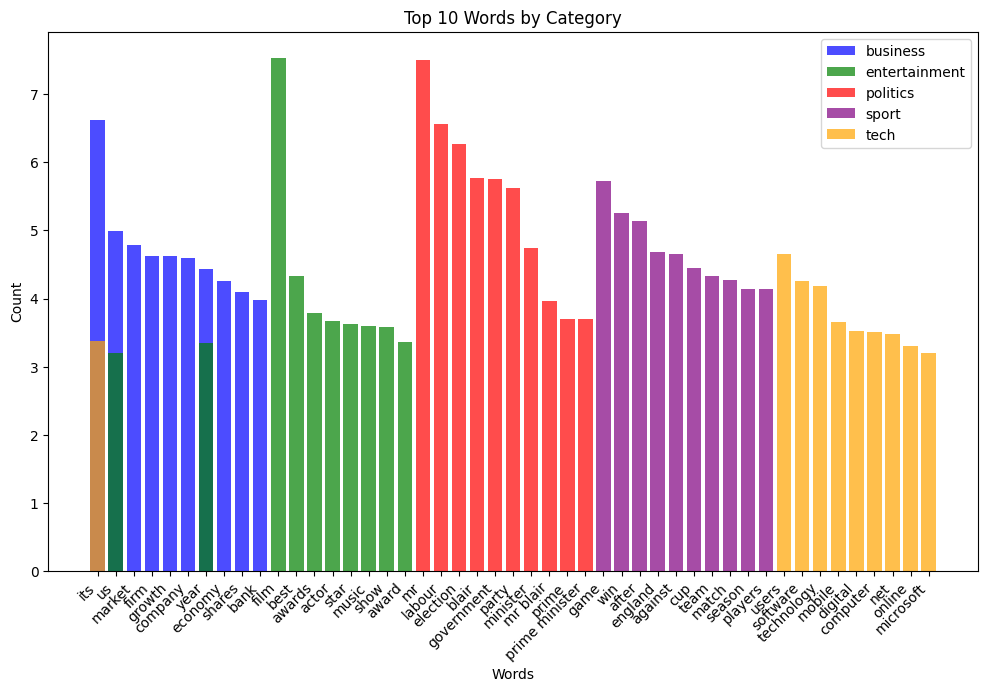

In [14]:
stopwords = pd.read_csv("https://gist.githubusercontent.com/deekayen/4148741/raw/98d35708fa344717d8eee15d11987de6c8e26d7d/1-1000.txt", header = None)[0:100]
vectorizer = TfidfVectorizer(input='content', encoding='utf-8', 
                             decode_error='strict', strip_accents='unicode', 
                             lowercase=True, preprocessor=None, tokenizer=None, 
                             analyzer='word', max_df=1.0, min_df=1, max_features=None, 
                             sublinear_tf=True, ngram_range=(1,2), stop_words = stopwords.T.values.tolist()[0])
#Vectorize Results
text_matrix = vectorizer.fit_transform(data.Text)
#Sparse Matrix of results
#print(text_matrix)
#Get Word List
word_list = vectorizer.get_feature_names_out()
# Convert sparse matrix to array
text_array = text_matrix.toarray()

# Create pandas dataframe with column names as word_list
text_dataframe = pd.DataFrame(text_array, columns=word_list)
text_dataframe.index = list(data.Category)
# Print first few rows of resulting dataframe
#print(text_dataframe.head())
#print(text_dataframe.shape)
graph_frame(text_dataframe)

I considered cleaning up this more to get more pure data, however I decided that it would be more intresting to leave the data with some ambiguities in words to see what would happen.

Now I will use Non\-Negative Matrix Factorization to reduce the size of the data set.  I will begin with a 90/10 train test split and move down to 50/50 20/80 and 10/90 to compare.  I will also see if I can find a most efficient C value for shrinking the dataset.   These initial steps are all being set up as funcitons so I can automate and make pretty graphs later on. 

To start with, I will split my data into train and test sets.  I split the data 90/10 and verified that the categories are similar in size.



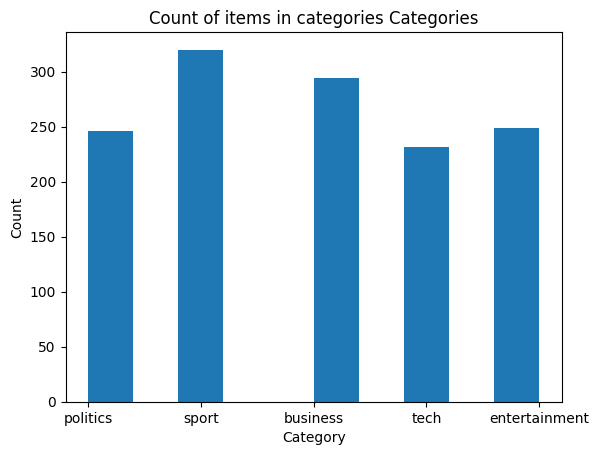

In [15]:
#Function to split the data and drop a chart to verify that the 
def split_data(df, percent):
    train_data, test_data = train_test_split(df, train_size=percent/100, random_state=42)    
    return train_data, test_data

train_data, test_data = split_data(text_dataframe, 90)
plot_balance(train_data)

As you can see, the datasets are similar in size preventing the need for normalizaiton.

Using T-SNE, the data is clearly categorized even when dimmension reduced to 2 factors.  There are some outliers, but it is pretty good.  The number of outliers may restrict me from usng a nearest neighbor model on the transformed data later on.

(1490, 2)


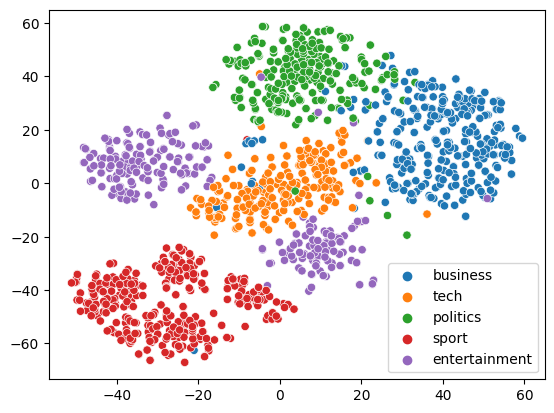

In [16]:
tsne = TSNE(n_components=2, random_state=42)
graph_vals = tsne.fit_transform(text_dataframe)
print(graph_vals.shape)
plot3 = sns.scatterplot(x = graph_vals[:,0], y = graph_vals[:,1], hue = text_dataframe.index)

**Data Transformation**
I started with a C of 50 for data transformation.  This is a very large value to start with, but I had to start somewhere.  A C of 50 doesn't work well and exceeds the 200 iteration threshold to properly calclate.  

In [17]:
#Copied from https://towardsdatascience.com/using-nmf-to-classify-companies-a77e176f276f
def create_model(train_data, c):
    #print(train_data)
    #train_data = csr_matrix(train_data)
    model = NMF(n_components=c, init='random', random_state=0, solver = 'mu')
    model = model.fit(train_data, c)
    #H = model.components_
    #err = model.reconstruction_err_
    return (model)
train_model = create_model(train_data, 50)

In [18]:
#print(train_model.transform(train_data).shape)
#print(train_model.transform(train_data))

## Initial Model Testing

I want to compare models at this size so I will test a variety of modles to see which one does the best at 50 factors.  I plan to test K-Means, and Hierarchical clustering for unsupervised.  I wall aslo use Random Forrest, and KNN as a Supervised comparison.  I will be testing these all on 50, 40, 30, 20, 15, 10, 5, 3, and 2 factors.  The train/test splits will be 90/10, 50/50, 20,80, and 10,90.  This will generate a great many confusion matricies and take a long time to calculate all of this.  I will embed static images for you to not have to run everyting over a few hours.

**K-Means**

K-Means was used with Train N /5 clusters.  The multiplicative solver was used to speed up solve time.  After clusers were built, each cluster was assigned a category based on the most common category for each.  The test set was predicted and the categories were tested on the training categories.

**Heirarcheral Agglomerative Clustering**

Heirarcheral Agglomerative Clustering is a unsupervised teqnique that is common for text analasys.  This uses a bottom up teqnique to combine points until a prediciton tree is built.  Agglomerative clustering is designed to cluser data and does not have the ability to predict new points.  Theirfore I will be only calculating the success of clustering the training set and evaluating which points do not match the larger group.  I will be using the N/5 clusters.

**Random Forrest**

Random forrest is a similar teqnique to Heirarcheral Agglomerative Clustering,  however random forrest works from the top down to the leaves splitting on categories.  I will use random forrest with the min split being 5 points and 100 random trees.

**K-Nearest Neighbor**

KNN is a classification algorithim that uses the nearest neighbors to classify points.  This teqnique is part of how Agglomerative Clustering chooses it's cluster points, however KNN chooses the category based on the nearest neighbors while Agglomerative Clustering uses this to determine clusters as a unsupervised teqnique.  I will be using 1, 3, and 5, endpoints.

In [19]:
def K_Means_Build_and_Test(train_W, test_W, train_data, test_data):
    n_clusters = int(train_W.shape[0]/10)
    model = KMeans(n_clusters=n_clusters, max_iter=300, n_init = 'auto')
    fitted_data = model.fit(scale(train_W))
    
    #use train data labels with W to label each cluster
    train_predict = model.predict(scale(train_W))
    train_predict = pd.DataFrame(zip(train_data.index, train_predict), columns = ['label', 'group'])
    #print(train_predict_labels.groupby(['group', 'label']).size())
    val = train_predict.groupby(['group', 'label']).size().to_frame()
    train_predict = val.loc[val.groupby("group")[0].idxmax()][0]
    #print(train_predict)
    train_predict_labels = pd.DataFrame(list(train_predict.index), columns = ['group', 'label'])
    #print(train_predict_labels)
    
    #Use transformed test data to predict 
    test_predict = model.predict(scale(test_W))
    test_predict_labels = pd.DataFrame(zip(test_data.index, test_predict), columns = ['actual', 'group'])
    
    #Validate predictions on test lables
    test_predict_labels['label'] = None
    test_predict_labels = test_predict_labels.merge(train_predict_labels, on = 'group', how = 'left')
    test_predict_labels = test_predict_labels.drop(['group', 'label_x'], axis = 1)
    test_predict_labels = test_predict_labels.rename({'actual' : 'actual', 'label_y': 'predict'}, axis = 1)
    #print(test_W.shape)
    #print(test_predict_labels)
    
    #return values for RMSE and F1    
    return test_predict_labels
    
#model_build_and_test(W, train_data, test_data, 50)

#df = K_Means_Build_and_Test(train_model.transform(train_data), train_model.transform(test_data), train_data, test_data)

def heiracheral_clustering(train_W, train_data):
    n_clusters = int(train_W.shape[0]/10)
    model = AgglomerativeClustering(n_clusters=n_clusters)
    fitted_data = model.fit_predict(scale(train_W))
    #use train data labels with W to label each cluster

    train_predict = pd.DataFrame(zip(train_data.index, fitted_data), columns = ['label', 'group'])
    #print(train_predict.shape)
    val = train_predict.groupby(['group', 'label']).size().to_frame()
    train_predict = val.loc[val.groupby("group")[0].idxmax()][0]
    train_predict_labels = pd.DataFrame(list(train_predict.index), columns = ['group', 'label'])

    #Use transformed test data to build test set 
    test_predict_labels = pd.DataFrame(zip(train_data.index, fitted_data), columns = ['actual', 'group'])
    
    #Validate predictions on test lables
    test_predict_labels['label'] = None
    test_predict_labels = test_predict_labels.merge(train_predict_labels, on = 'group', how = 'left')
    test_predict_labels = test_predict_labels.drop(['group', 'label_x'], axis = 1)
    test_predict_labels = test_predict_labels.rename({'actual' : 'actual', 'label_y': 'predict'}, axis = 1)
    #print(test_predict_labels)
    #Test for perfect predictions
    #print(sum(test_predict_labels['actual'] == test_predict_labels['predict']))
    return test_predict_labels
    
#Heiracheral_clustering(train_model.transform(train_data), train_data)

def random_forrest(train_W, test_W, train_data, test_data):
    #Generate Random Forrest and Fit Data
    model  = RandomForestClassifier(n_estimators=100, criterion='gini', 
                                    max_depth=None, min_samples_split=5, 
                                    min_samples_leaf=3, min_weight_fraction_leaf=0.0, 
                                    max_features='sqrt', max_leaf_nodes=None, 
                                    min_impurity_decrease=0.0, bootstrap=True, 
                                    oob_score=False, n_jobs=None, random_state=None, 
                                    verbose=0, warm_start=False, class_weight=None, 
                                    ccp_alpha=0.0, max_samples=None)
    
    model.fit(scale(train_W), train_data.index)
    #predict test set
    test_predict = model.predict(scale(test_W))
    test_predict_labels = pd.DataFrame(zip(test_data.index, test_predict), columns = ['actual', 'predict'])
    #print(test_predict_labels)
    #print(sum(test_predict_labels['actual'] == test_predict_labels['predict']))
    return(test_predict_labels)

#random_forrest(train_model.transform(train_data), train_model.transform(test_data), train_data, test_data)

def nearest_neighbor(train_W, test_W, train_data, test_data, n_neighbors):
    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights='uniform', 
                                 algorithm='auto', leaf_size=30, p=2, 
                                 metric='minkowski', metric_params=None, 
                                 n_jobs=None)
    model.fit(scale(train_W), train_data.index)
    test_predict = model.predict(scale(test_W))
    test_predict_labels = pd.DataFrame(zip(test_data.index, test_predict), columns = ['actual', 'predict'])
    #print(sum(test_predict_labels['actual'] == test_predict_labels['predict']))
    #print(test_predict_labels)
    return(test_predict_labels)
df = nearest_neighbor(train_model.transform(train_data), train_model.transform(test_data), train_data, test_data, 1)  

def make_metrics(df):
    f1 = f1_score(df['actual'], df['predict'], average='macro')
    f1 = "F1 Score: " + str(round(f1, 5))
    precision = precision_score(df['actual'], df['predict'], average='macro')
    precision = "Precsion: "+ str(round(precision, 5))
    recall =  recall_score(df['actual'], df['predict'], average='macro')
    recall = "Recall: "+ str(round(recall, 5))
    return (f1, precision, recall)

# Confusion Matrix From https://vitalflux.com/python-draw-confusion-matrix-matplotlib/#Confusion_Matrix_using_Matplotlib
def make_confusion_matrix(df, title, axes, first_row = 0):
    labels = np.array(['business', 'entertainment', 'politics', 'sports', 'tech'])
    cm = confusion_matrix(df['actual'], df['predict'], labels = labels)
    #print(cm)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
    cm_display = cm_display.plot(ax=axes, xticks_rotation=30)
    cm_display.ax_.set_title(title)
    if first_row == 1:
        cm_display.ax_.set_xlabel("")
        cm_display.ax_.set_ylabel("Actual")
    else: 
        cm_display.ax_.set_xlabel("")
        cm_display.ax_.set_ylabel("")
        cm_display.ax_.get_yaxis().set_visible(False)
        
    cm_display.im_.colorbar.remove()
    cm_display.ax_.text(0.5, -0.3, "\n".join(list(make_metrics(df))), transform=cm_display.ax_.transAxes,
                                     horizontalalignment='center', verticalalignment='top')
    return cm_display
    
    
#make_confusion_matrix(df, "Title")

#print(make_metrics(df))
def make_metrics_clean(df):
    f1 = f1_score(df['actual'], df['predict'], average='macro')
    precision = precision_score(df['actual'], df['predict'], average='macro')
    recall =  recall_score(df['actual'], df['predict'], average='macro')
    return (f1, precision, recall)


# Caution.  This takes a very long time to run.  Static Image Results Below.  Uncomment this block if you want to wait an hour or 2 for the this all to run.

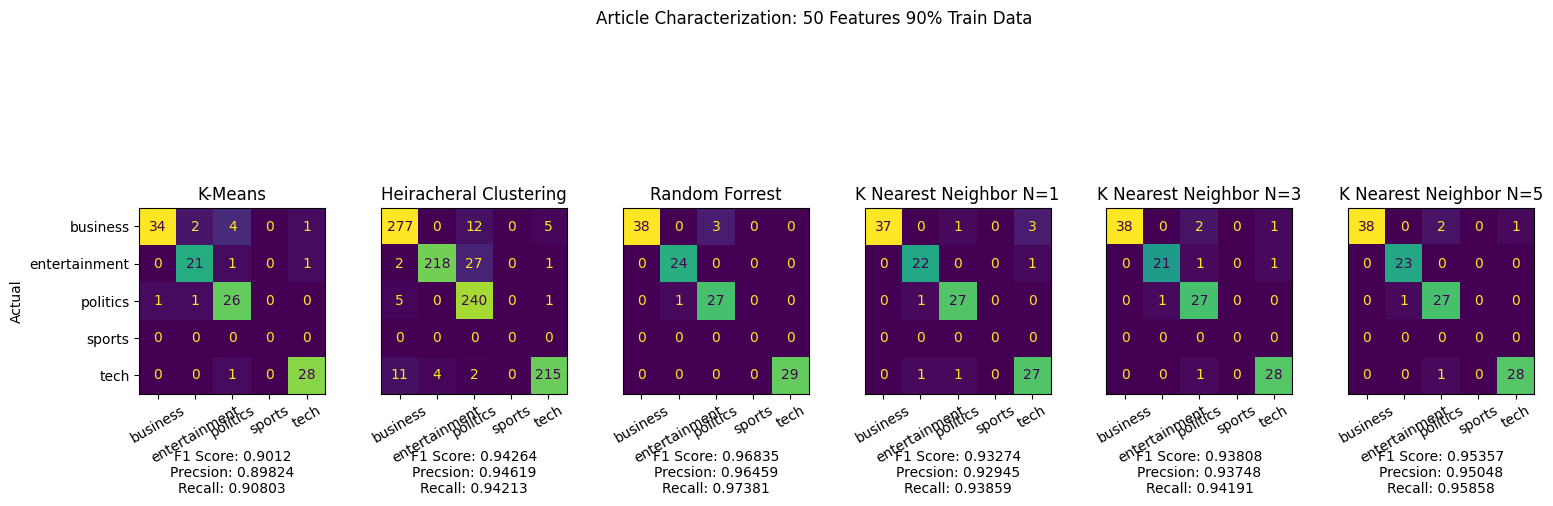

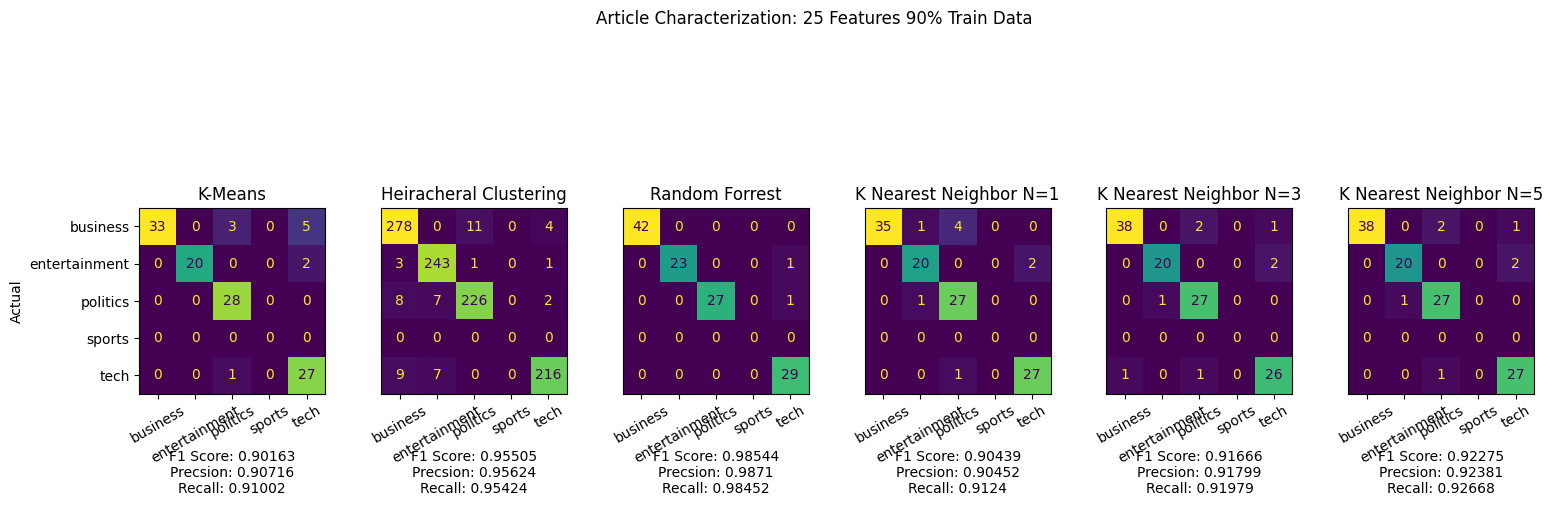

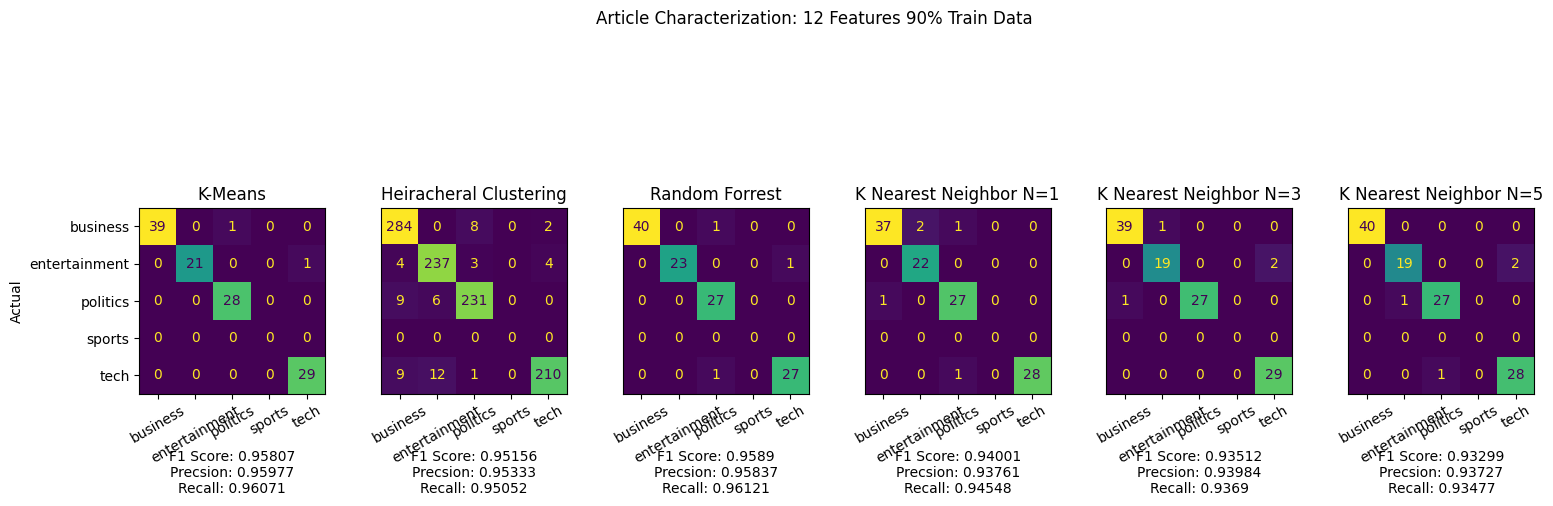

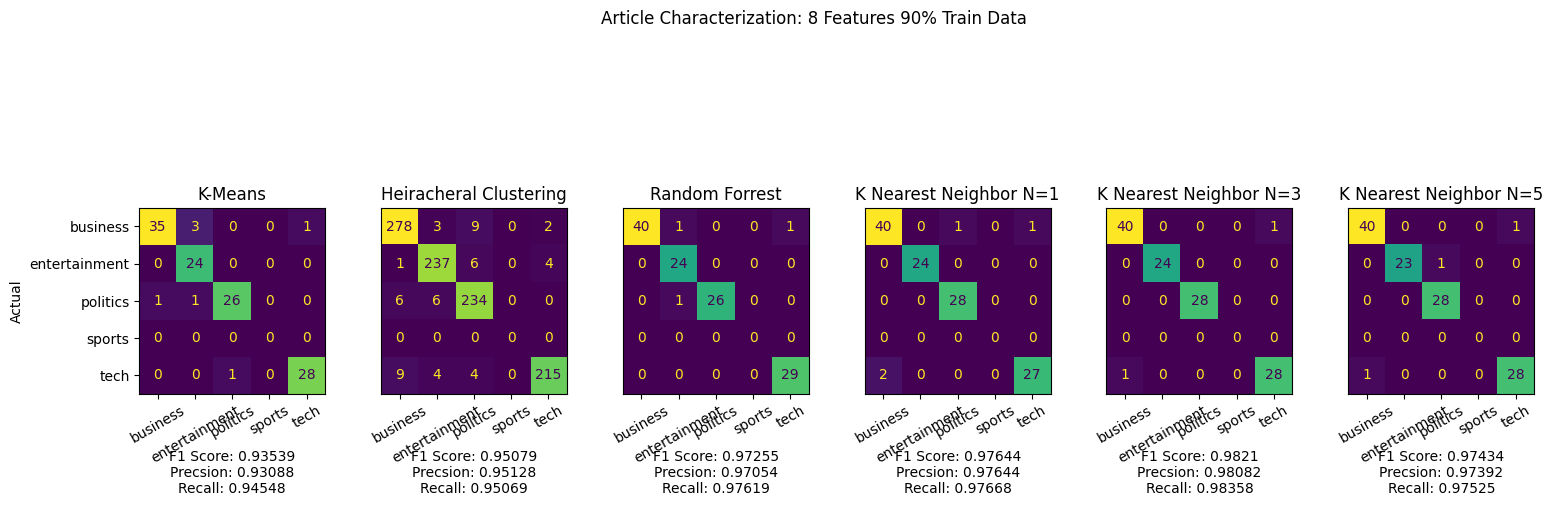

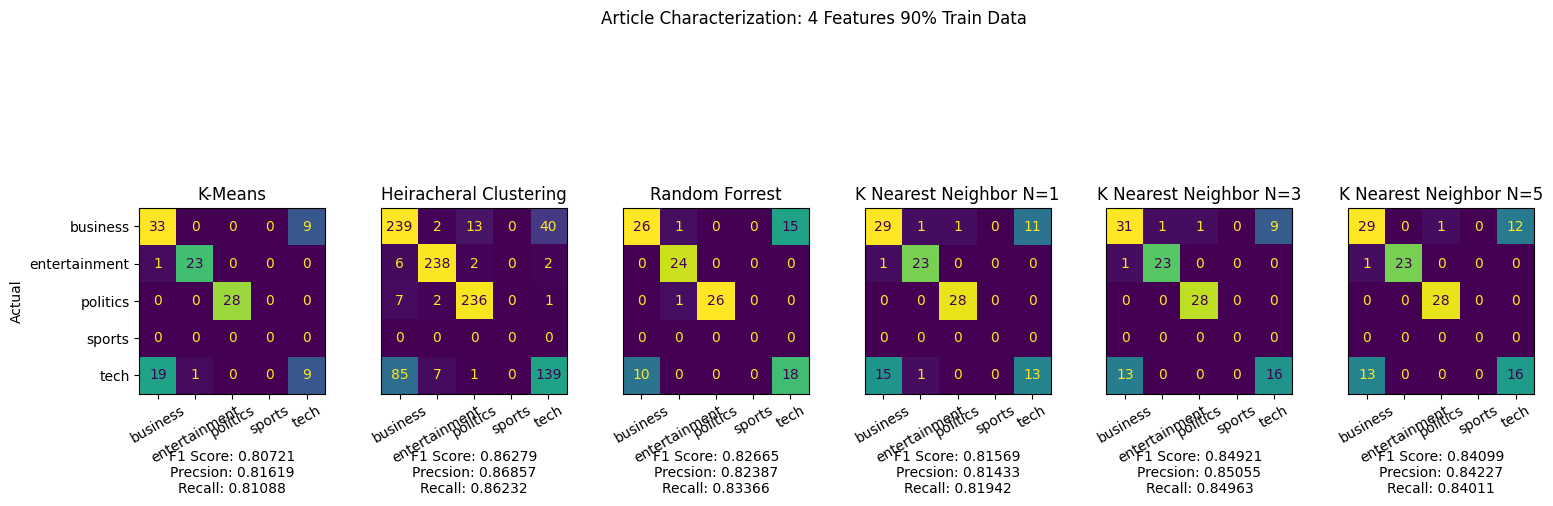

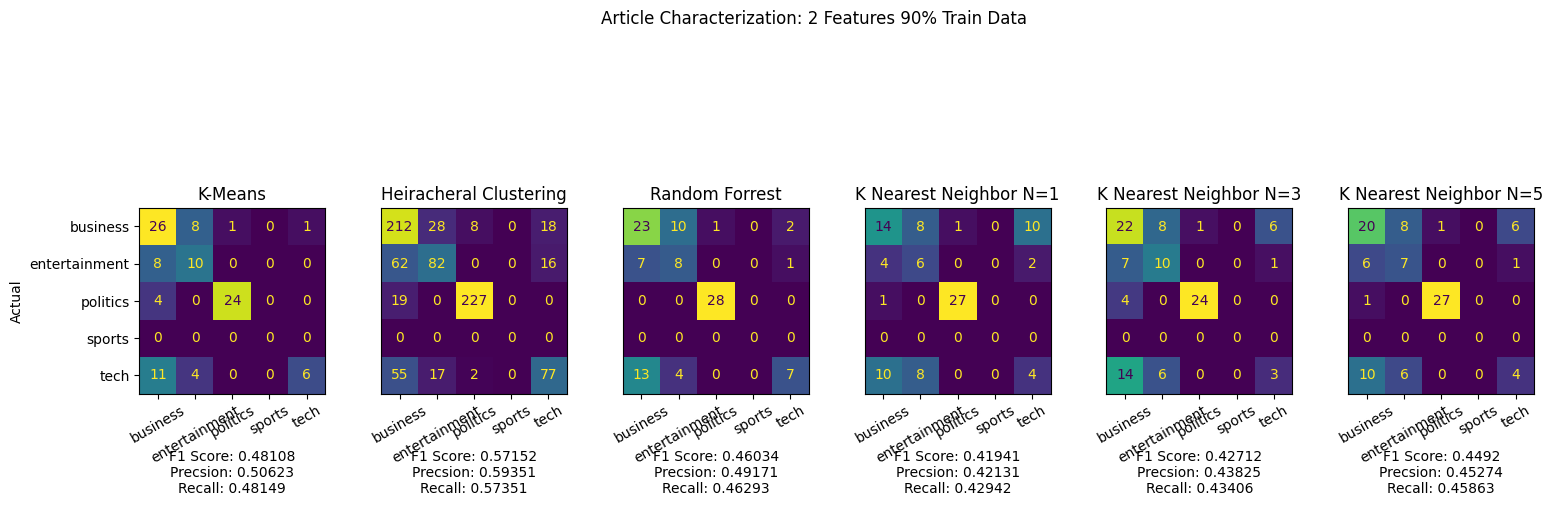

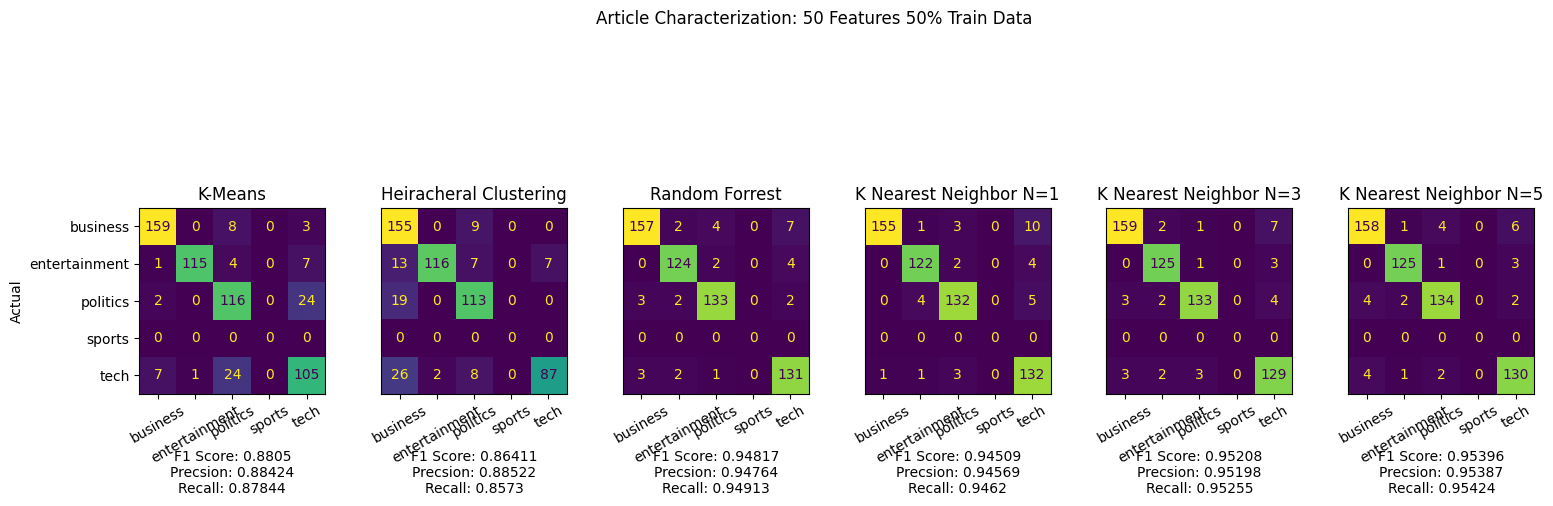

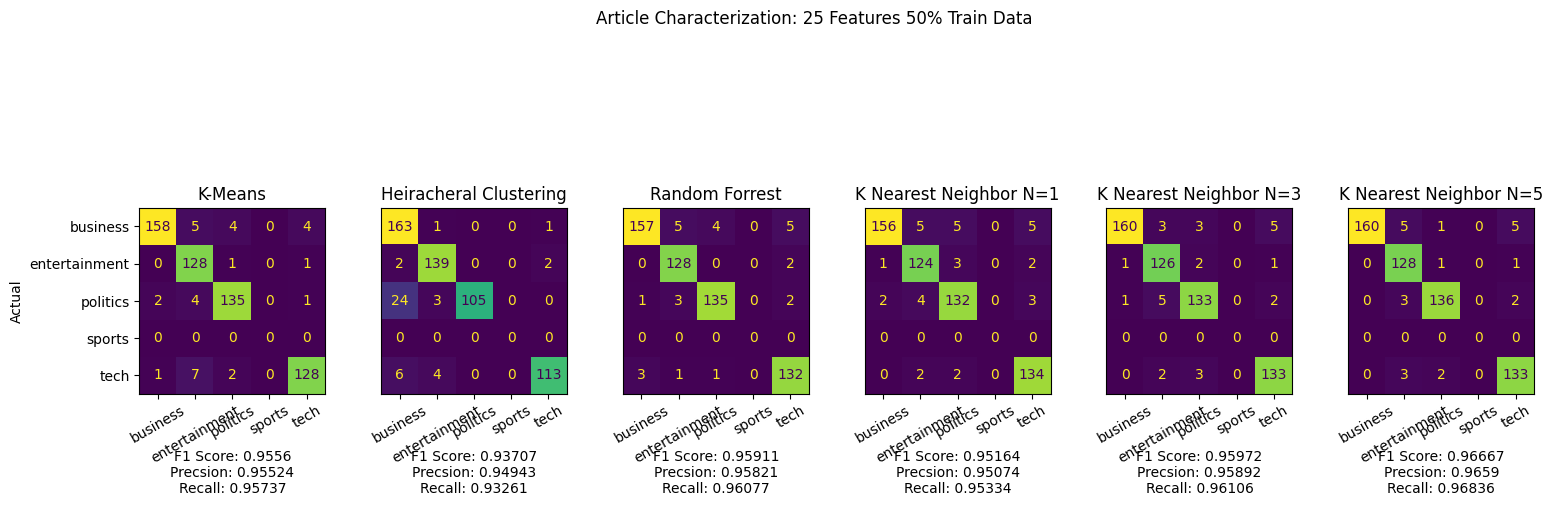

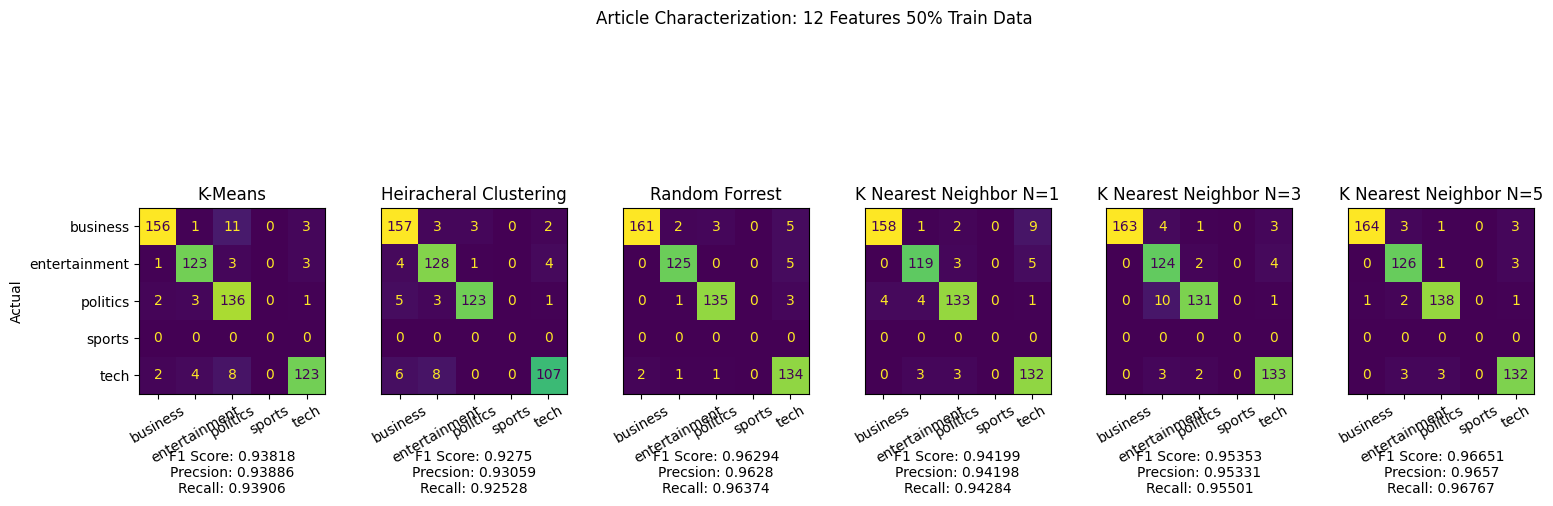

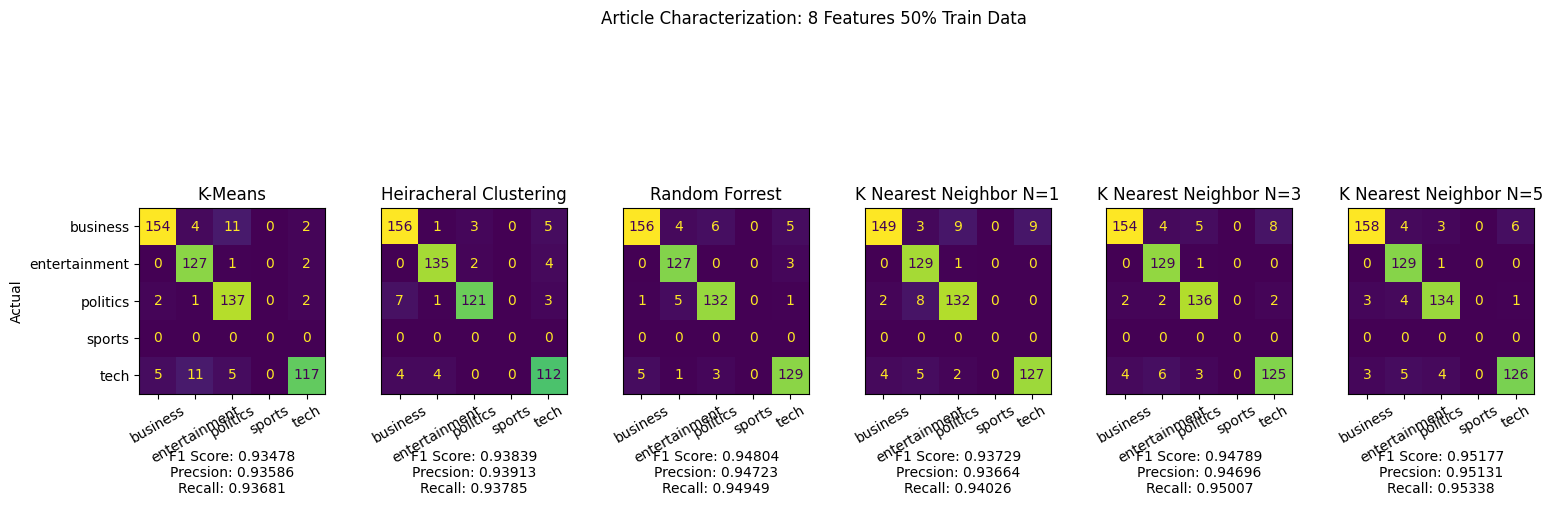

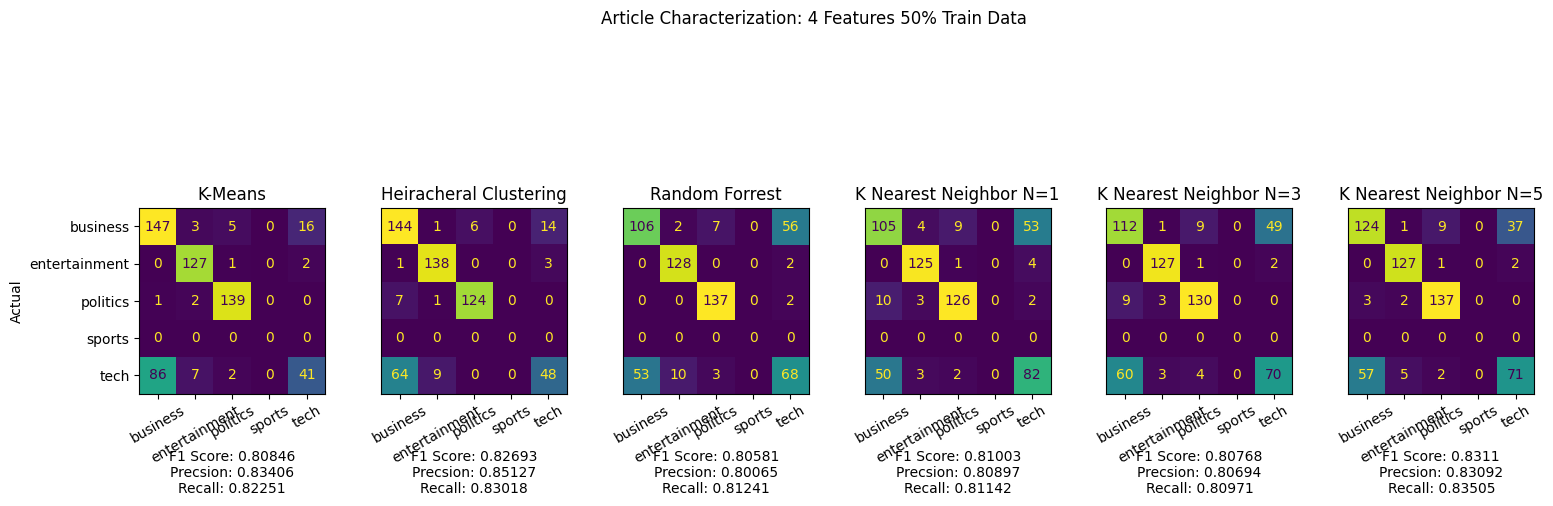

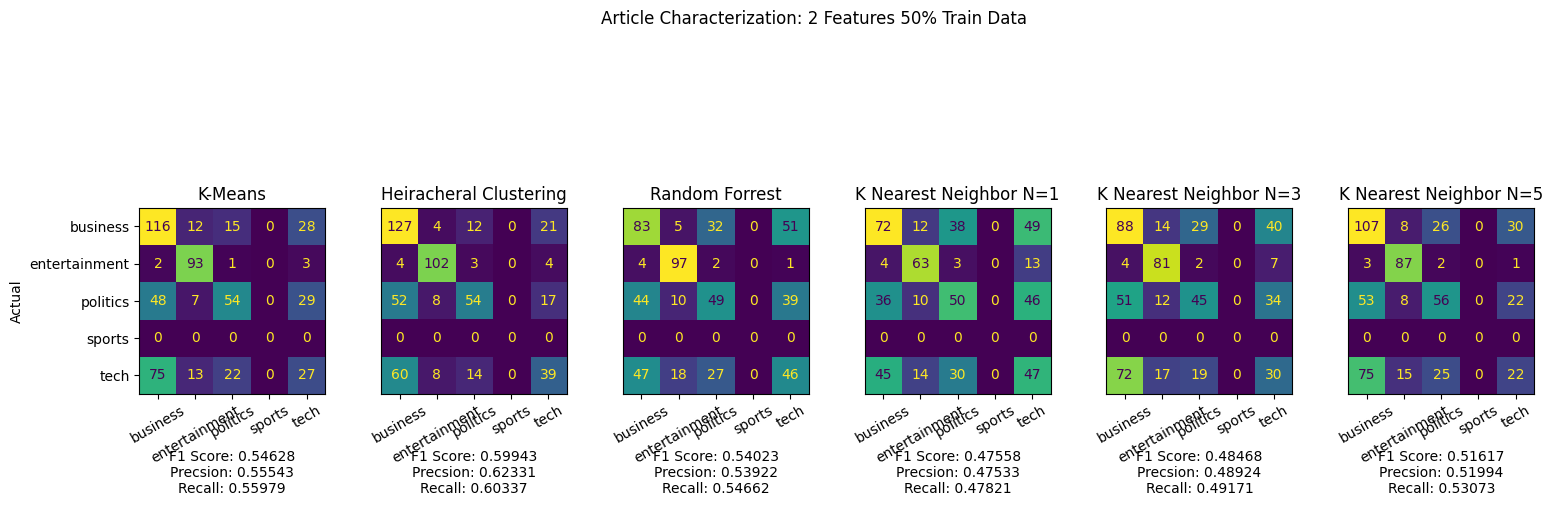

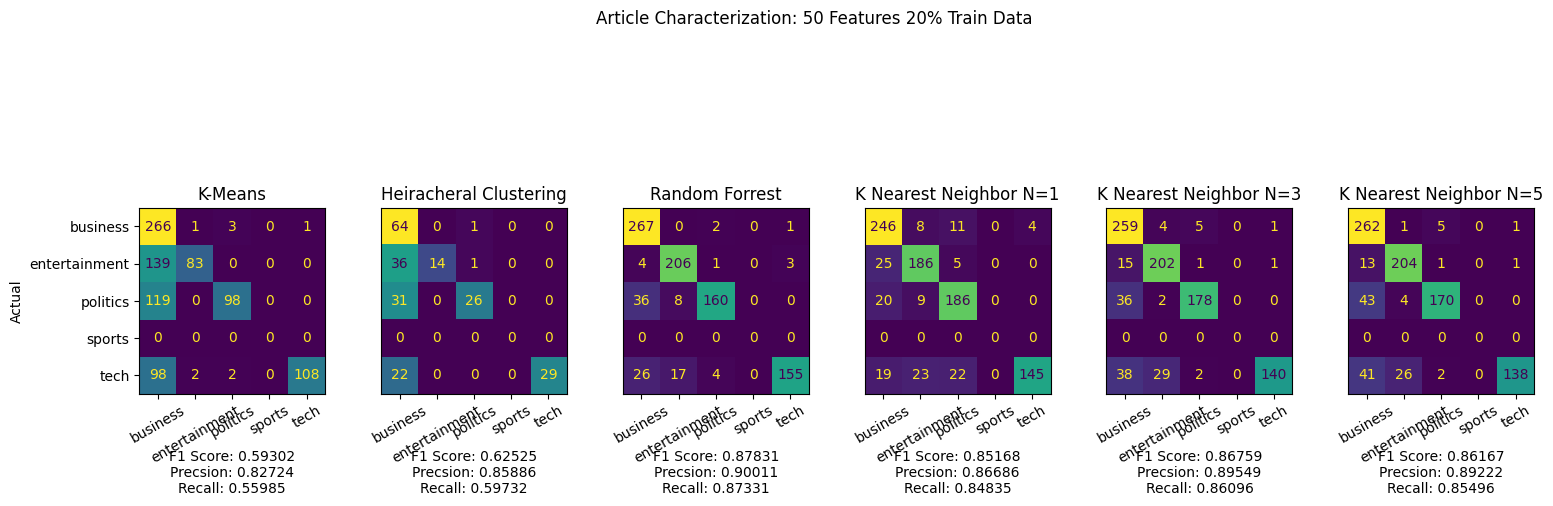

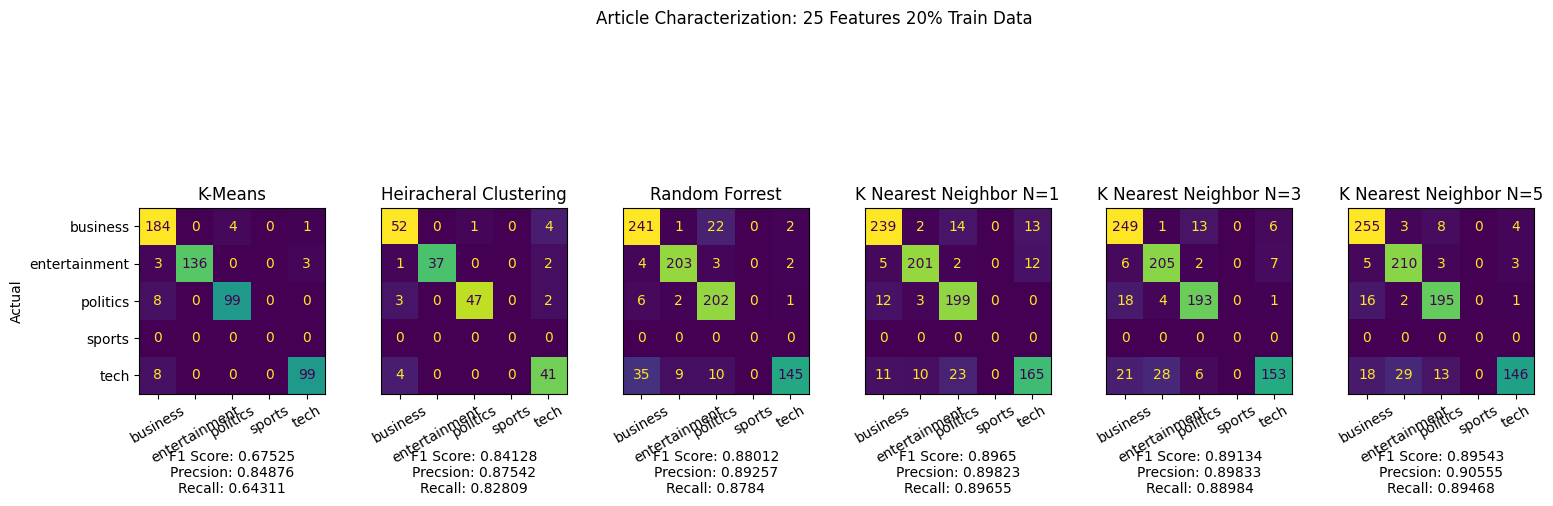

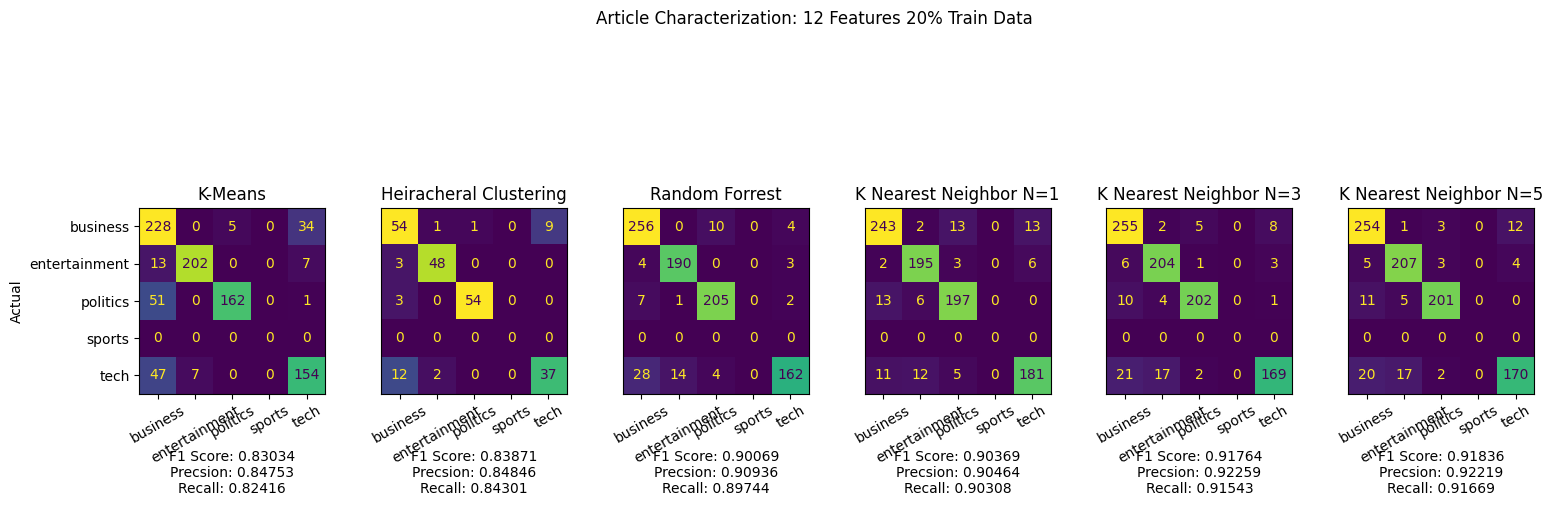

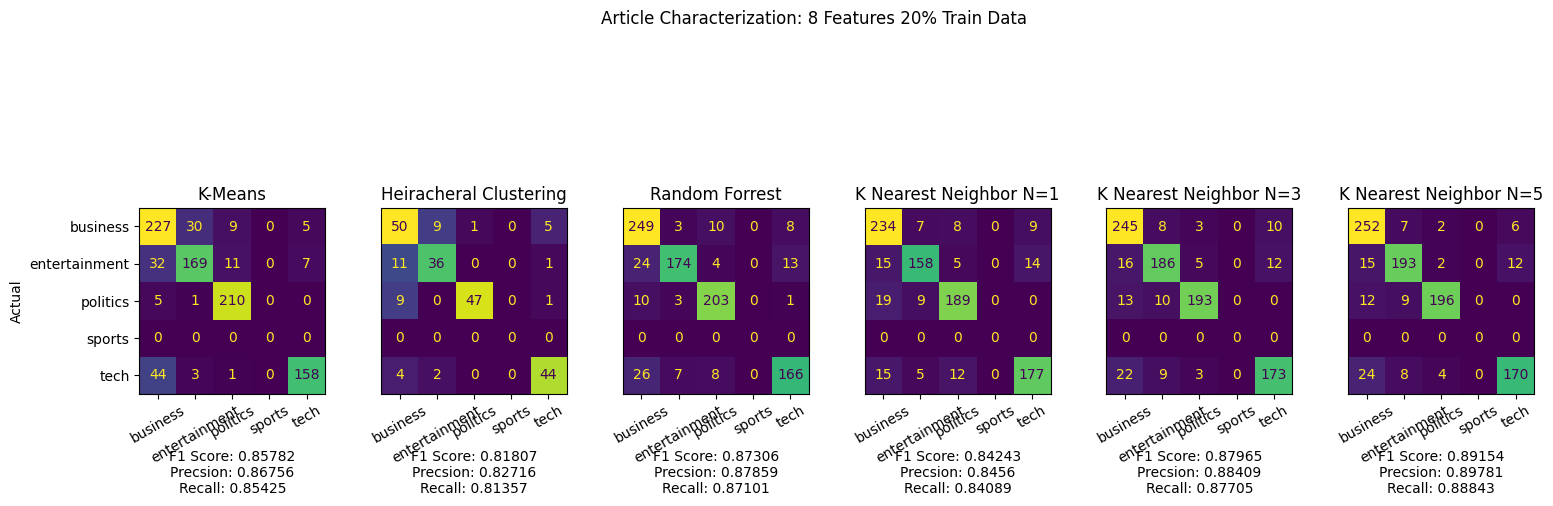

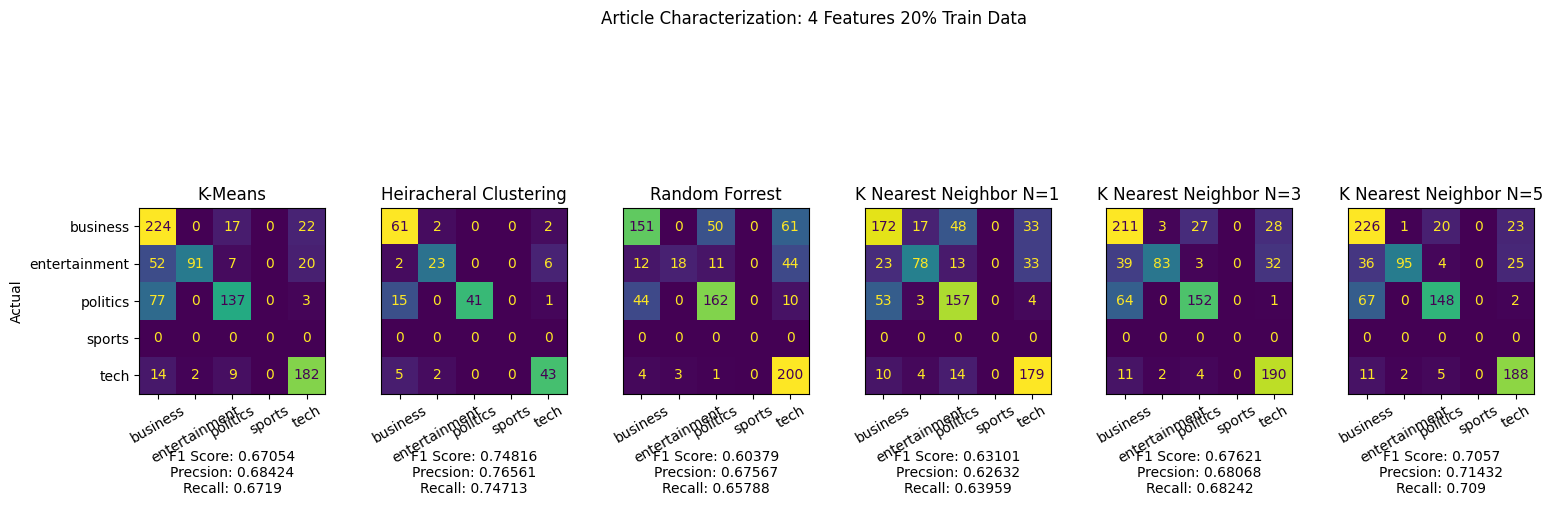

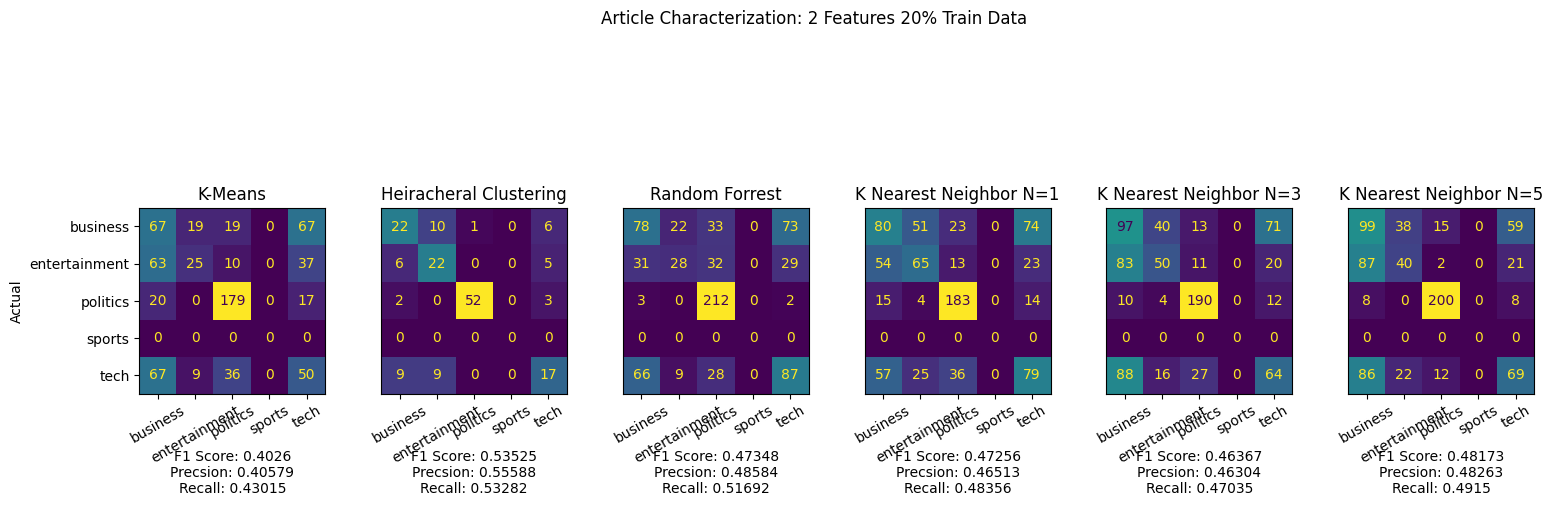

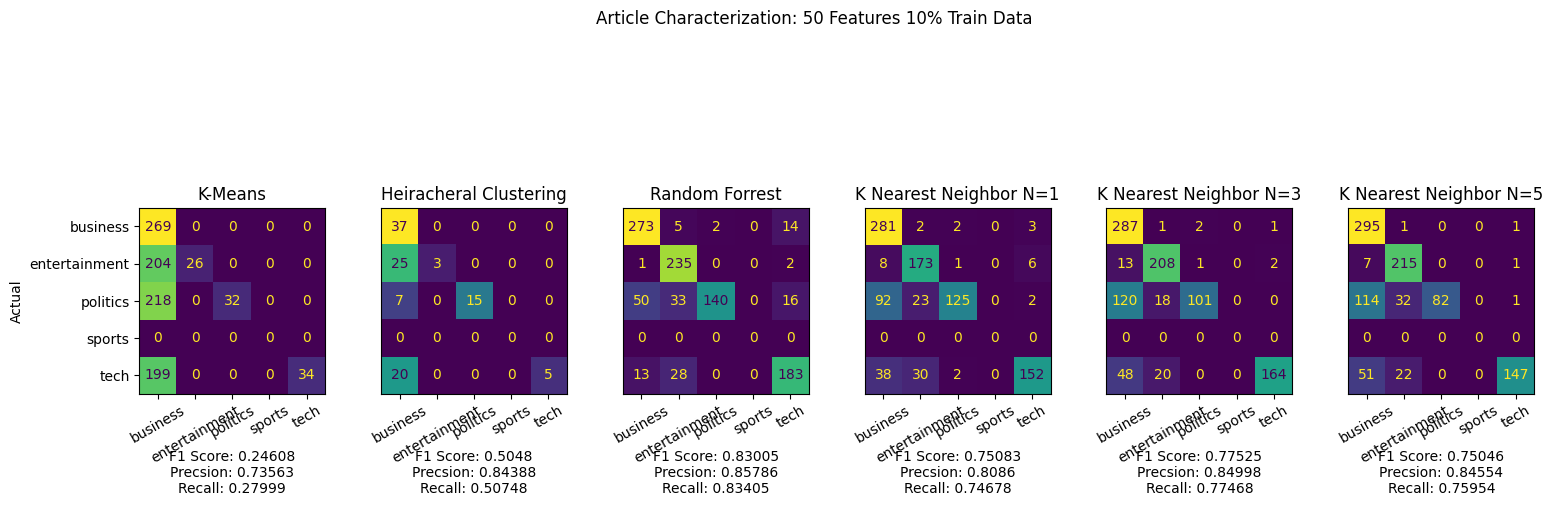

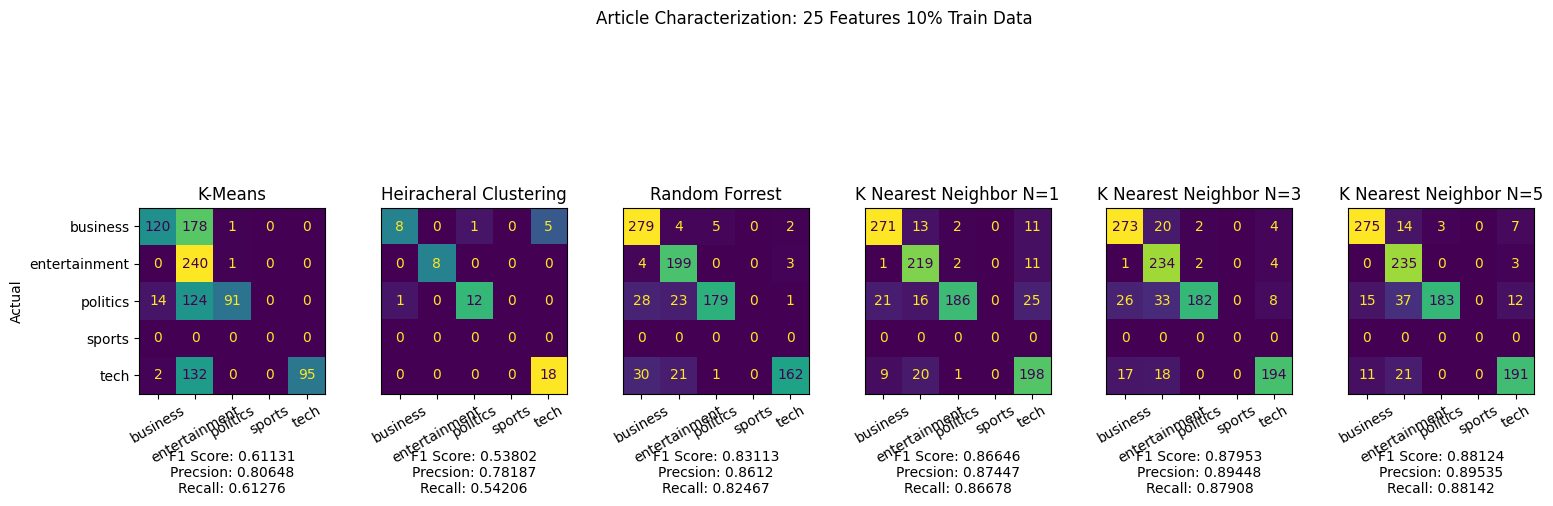

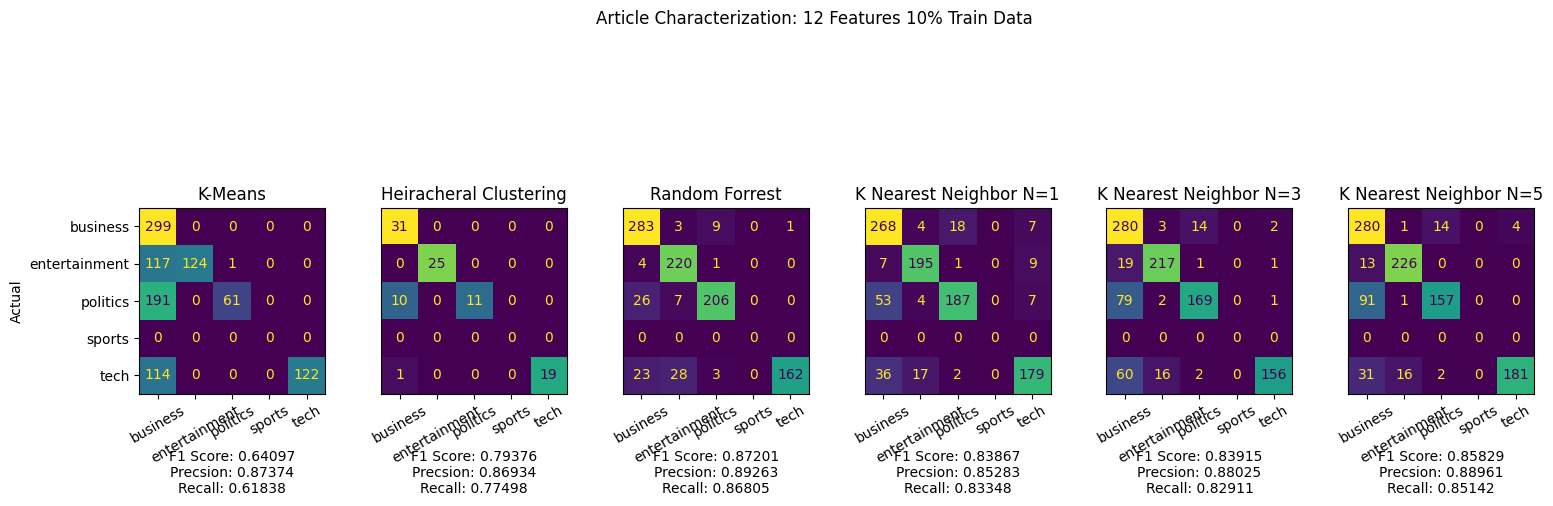

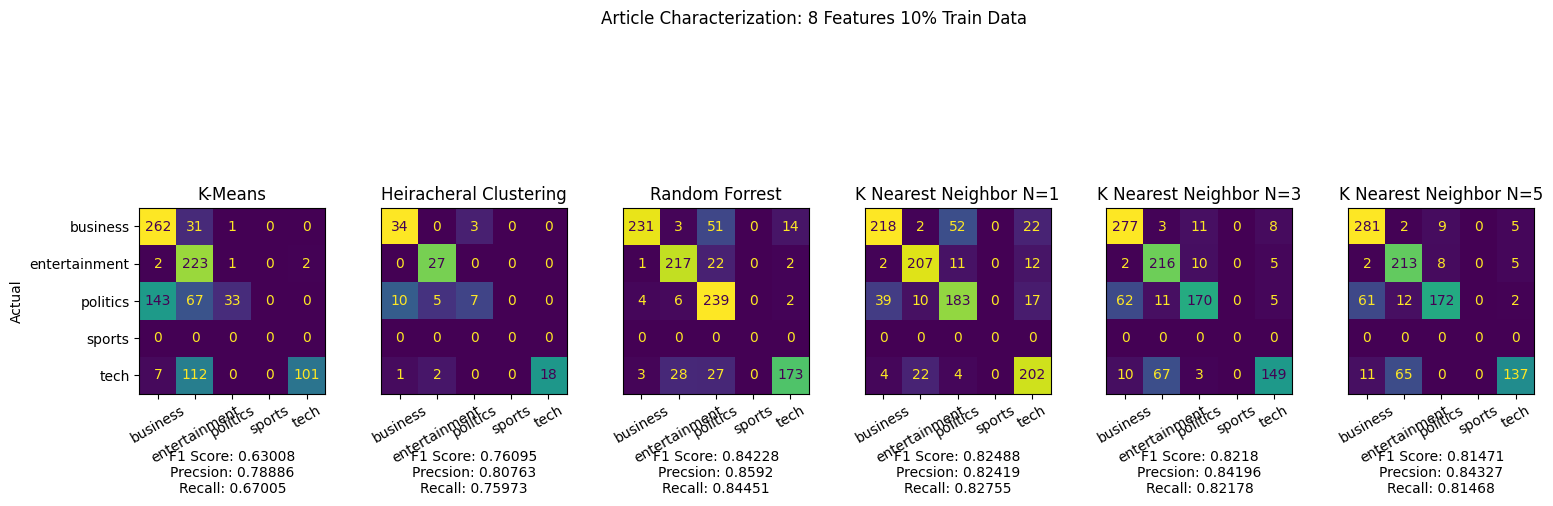

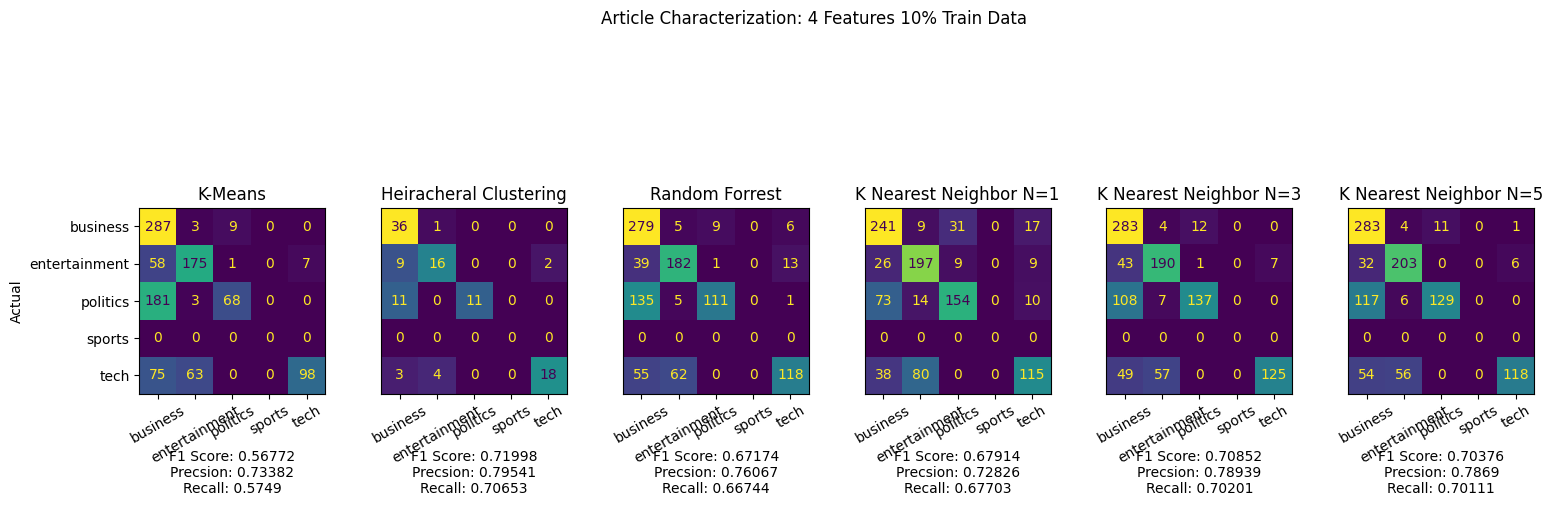

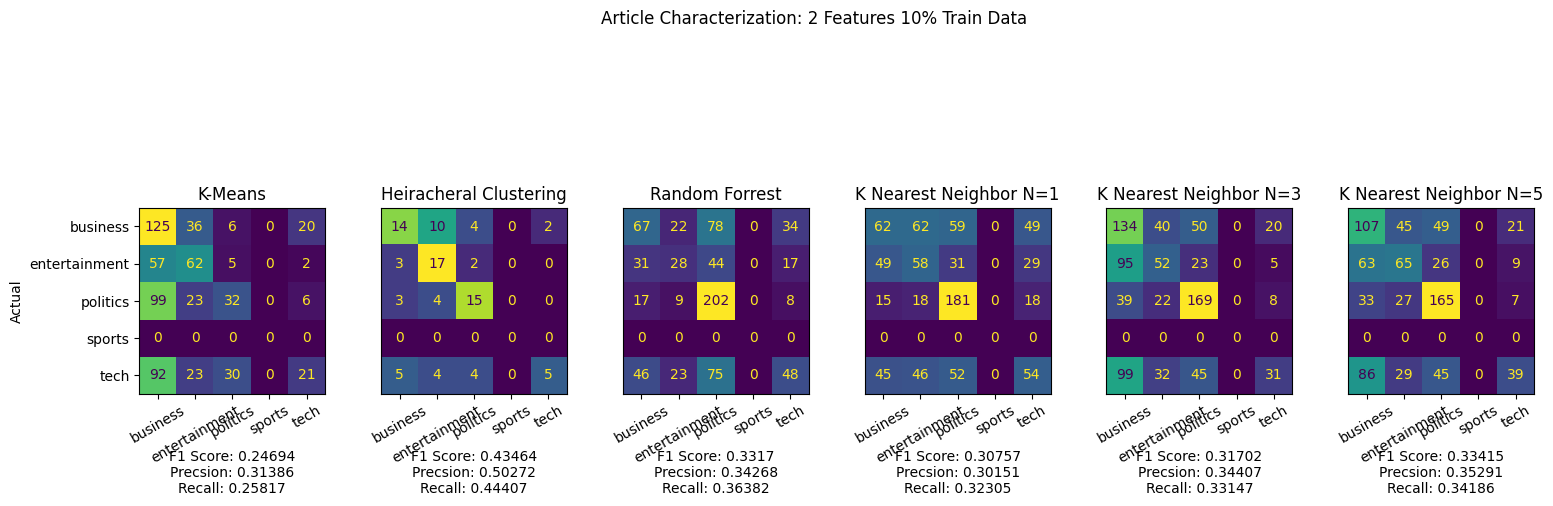

In [20]:

def model_build_and_test(train_data, test_data, C, data_split):
    #C will be a list of C values to test
    # Build W and test W
    
    this_c = C
    train_model= create_model(train_data, this_c)
    train_W = train_model.transform(train_data)
    test_W = train_model.transform(test_data)
    #K-Means
    
    KMC = K_Means_Build_and_Test(train_model.transform(train_data), 
                                 train_model.transform(test_data), 
                                 train_data, test_data)
    
    #Hierarchical clustering
    HC = heiracheral_clustering(train_model.transform(train_data), 
                                train_data)
    
    #Random Forrest
    RMF = random_forrest(train_model.transform(train_data), 
                         train_model.transform(test_data), 
                         train_data, test_data)

    
    #KNN 1, 3, and 5 nearest neighbors
    KNN1 = nearest_neighbor(train_model.transform(train_data), 
                            train_model.transform(test_data), 
                            train_data, test_data, 1)
    KNN3 = nearest_neighbor(train_model.transform(train_data), 
                            train_model.transform(test_data), 
                            train_data, test_data, 3)
    KNN5 = nearest_neighbor(train_model.transform(train_data), 
                            train_model.transform(test_data), 
                            train_data, test_data, 5)
    
    f1_data = pd.DataFrame([[make_metrics_clean(KMC)[0], make_metrics_clean(HC)[0], 
                            make_metrics_clean(RMF)[0], make_metrics_clean(KNN1)[0], 
                            make_metrics_clean(KNN3)[0], make_metrics_clean(KNN5)[0],
                            C, data_split, "F1"]],   
                           columns = ['KMC', 'HC', "RMF", 'KNN1', "KNN3",
                                      "KNN5", "C", "data_split", "type"])
    precision = pd.DataFrame([[make_metrics_clean(KMC)[1], make_metrics_clean(HC)[1], 
                            make_metrics_clean(RMF)[1], make_metrics_clean(KNN1)[1], 
                            make_metrics_clean(KNN3)[1], make_metrics_clean(KNN5)[1],
                            C, data_split, "precision"]],   
                           columns = ['KMC', 'HC', "RMF", 'KNN1', "KNN3",
                                      "KNN5", "C", "data_split", "type"])
    recall = pd.DataFrame([[make_metrics_clean(KMC)[2], make_metrics_clean(HC)[2], 
                            make_metrics_clean(RMF)[2], make_metrics_clean(KNN1)[2], 
                            make_metrics_clean(KNN3)[2], make_metrics_clean(KNN5)[2],
                            C, data_split, "recall"]],   
                           columns = ['KMC', 'HC', "RMF", 'KNN1', "KNN3",
                                      "KNN5", "C", "data_split", "type"])
    
    f1_data = pd.concat([f1_data, precision, recall], axis = 0)
    # Create the figure and axes


    fig, axs = plt.subplots(1, 6, figsize=(18, 6))    
    disp0 = make_confusion_matrix(KMC, "K-Means", axs[0], 1)
    disp1 = make_confusion_matrix(HC, "Heiracheral Clustering", axs[1])
    disp2 = make_confusion_matrix(RMF, "Random Forrest", axs[2])
    disp3 = make_confusion_matrix(KNN1, "K Nearest Neighbor N=1", axs[3])
    disp4 = make_confusion_matrix(KNN3, "K Nearest Neighbor N=3", axs[4])
    disp5 = make_confusion_matrix(KNN5, "K Nearest Neighbor N=5", axs[5])

    # Adjusting spacing between subplots
    plt.subplots_adjust(wspace=0.3)
    title = "Confusion Matricies/Confusion " + str(C) + " Features " + str(data_split) + " Train Data" 
    plt.savefig(title +".png")
    title = "Article Characterization: " + str(C) + " Features " + str(data_split) + "% Train Data" 
    # Display the plot
    fig.suptitle(title)
    plt.show()
    return f1_data

f1_data = pd.DataFrame()
c_values = [50, 25, 12, 8, 4, 2]
data_split_values = [90, 50, 20, 10]
#split_data(df, percent)
#pd.concat([f1_data, model_build_and_test(train_data, test_data, 50, 90)], axis = 0)
#print(f1_data)

for percent in data_split_values:
    train_data, test_data = split_data(text_dataframe, percent)
    for c in c_values:
        f1_new = model_build_and_test(train_data, test_data, c, percent)
        f1_data = pd.concat([f1_data, f1_new], axis = 0)
#save data for late use when this is blocked out.
f1_data.to_csv('f1_data.csv')       

**Confusion Matrixs**

https://github.com/isaac1987a/Week-4/tree/main/BBC/Confusion%20Matricies


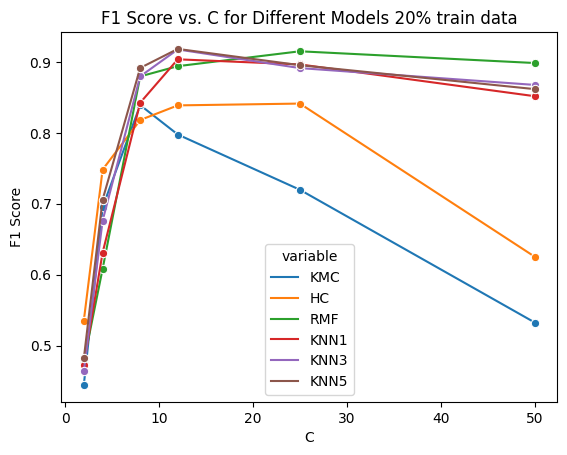

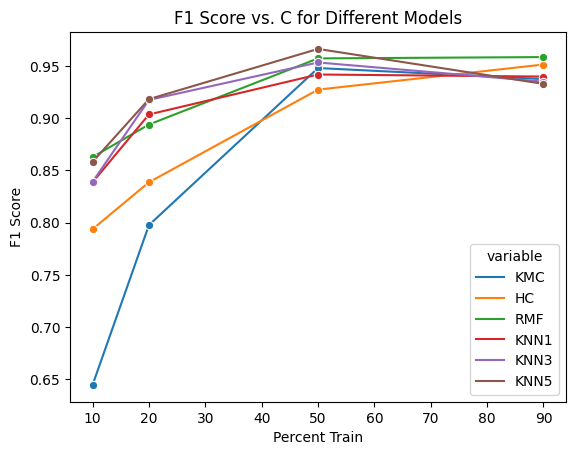

In [21]:
#Load data from skipped step
f1_data = pd.read_csv('https://raw.githubusercontent.com/isaac1987a/Week-4/main/BBC/f1_data.csv?token=GHSAT0AAAAAACEVGSIIREHWH2ZYGII3JA4KZFMJTFA')
#print(f1_data)
#Format Data
f1_data = f1_data.drop('Unnamed: 0', axis = 1)
new_data = f1_data.melt(id_vars=['data_split', 'C', 'type'])
new_data['C'] = new_data['C'].astype('category')
new_data['data_split'] = new_data['data_split'].astype('category')
    
#C/F1 Score Train 20% data
new_data = new_data.loc[(new_data['data_split'] == 20) & (new_data['type'] == 'F1')]
#print(new_data)
sns.lineplot(data=new_data, x='C', y='value', hue='variable', marker ='o')

# Adding labels and title
plt.xlabel('C')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. C for Different Models 20% train data')

# Displaying the plot
plt.show()


#train_data/F1 Score C=12
new_data = f1_data.melt(id_vars=['data_split', 'C', 'type'])
new_data['C'] = new_data['C'].astype('category')
new_data['data_split'] = new_data['data_split'].astype('category')
    
#C/F1 Score Train 20% data
new_data = new_data.loc[(new_data['C'] == 12) & (new_data['type'] == 'F1')]
sns.lineplot(data=new_data, x='data_split', y='value', hue='variable', marker ='o')

# Adding labels and title
plt.xlabel('Percent Train')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. C for Different Models')

# Displaying the plot
plt.show()

## Analasys

There are a large amount of things we can extract from this about the models.  Using the NMF strips out the words but also reduces features.  Feature reduction seems to work better than not, as it reduces dimmentionality and works well on smaller amounts of data.  I chose to use F1 scores as the precision and recall scores fall in line with the F1 score.

**Variables Performance**
Reducing the number of factors "C Value" using NMF improved the performance of all of the unsupervised and supervised models.  This is likely due to finding the best medium to the curse of dimmioniality.  The best point was "C" of 12 in my testing.

**Train Test Split Performance**
The train test split had an impact on the F1 Scores.  The split of 50% of the data for train was the best point, with a moderate dropoff ~.05 at 20% train data.  Smaller train data can make faster training and for KNN, smaller training sets will result in a faster prediction.

**Model Performance**
The best performing models were Random Forrest and K-Nearest Neighbor N=5.  KNN and Random forrest work similary using 2 different methods but both find small clusters of points.

Heirarchaeral Clustering and K-Means clustrering worked less well, especially when the trainig set becomes small.  As both methods create clusters of points, the weakness probably comes when the number of points becomes too few and the size of clusters becomes very large.